<a href="https://colab.research.google.com/github/lewisevans38/Suez-Time-Series-Anomaly-Detection-/blob/main/LSTMAEonNAB_speed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Base code taken from
 https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/

 Modified where appropriate so that the code works for the NAB dataset and shows fit/ reconstruction error and detects anomalies.

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from matplotlib import pyplot as plt
import math
from copy import deepcopy
from sklearn.model_selection import train_test_split


In [ ]:
URL1= "https://raw.githubusercontent.com/numenta/NAB/master/data/realTraffic/speed_6005.csv"
DATA1 = pd.read_csv(URL1)
DATA1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
df = DATA1
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range =(-1,1))
scaler = scaler.fit(train[['value']])
train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])
df['value'] = scaler.transform(df[['value']])



(2000, 2) (500, 2)


<ipython-input-19-0d285568ce3f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['value'] = scaler.transform(train[['value']])
<ipython-input-19-0d285568ce3f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['value'] = scaler.transform(test[['value']])


In [ ]:
def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 5
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(
  train[['value']],
  train.value,
  TIME_STEPS
)
X_test, y_test = create_dataset(
  test[['value']],
  test.value,
  TIME_STEPS
)
print(X_train.shape)

##Turn into pytorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

print(X_train.shape)

(1995, 5, 1)
torch.Size([1995, 5, 1])


In [ ]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [ ]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [ ]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim)
    self.decoder = Decoder(seq_len, embedding_dim, n_features)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [ ]:
model = RecurrentAutoencoder(TIME_STEPS, 1, 64)
model = model.to(device)

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])
  best_model_wts = deepcopy(model.state_dict())
  best_loss = 10000.0
  for epoch in range(1, n_epochs + 1):
    model = model.train()
    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)
        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)
    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = deepcopy(model.state_dict())
    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [ ]:
model, history = train_model(
  model,
  X_train,
  X_test,
  n_epochs=60
)

Epoch 1: train loss 0.9257967018020482 val loss 0.7984886965065291
Epoch 2: train loss 0.6327737723712933 val loss 0.5324966025472891
Epoch 3: train loss 0.4324524820205711 val loss 0.3741620483723554
Epoch 4: train loss 0.3783625743125465 val loss 0.3455302234174627
Epoch 5: train loss 0.21987112794435562 val loss 0.1394087636975026
Epoch 6: train loss 0.13241938851624355 val loss 0.14419303066050163
Epoch 7: train loss 0.11793803047099359 val loss 0.12293666959410966
Epoch 8: train loss 0.12005318099805586 val loss 0.11212162032648168
Epoch 9: train loss 0.10816926132037974 val loss 0.1197543199766766
Epoch 10: train loss 0.09939248694811847 val loss 0.13685092334494448
Epoch 11: train loss 0.0930312188281526 val loss 0.105681295444568
Epoch 12: train loss 0.09573082246521213 val loss 0.16098223493406266
Epoch 13: train loss 0.09477069920913916 val loss 0.11781021145106566
Epoch 14: train loss 0.08930838065114535 val loss 0.09440763986321411
Epoch 15: train loss 0.08725548928281418 v

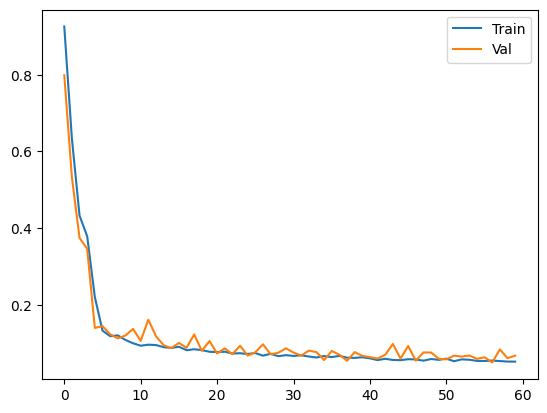

In [ ]:

plt.plot(history['train'], label = 'Train')
plt.plot(history['val'], label ='Val')
plt.legend()
plt.show()

In [ ]:
predictions = []
model = model.eval().to('cpu')
with torch.no_grad():
  for seq_true in X_train:

    seq_true = seq_true
    seq_pred = model(seq_true)
    predictions.append(seq_pred[:][-1].item())
  for seq_true in X_test:

    seq_true = seq_true
    seq_pred = model(seq_true)
    predictions.append(seq_pred[:][-1].item())



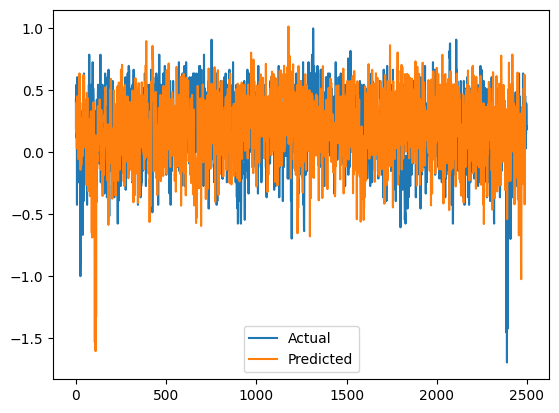

In [ ]:

plt.plot(df['value'], label = 'Actual')
plt.plot(predictions, label ='Predicted')
plt.legend()
plt.show()

This plot is backwards because of some code I ran to make sure my data was moving in the right direction. The plot that is included in the project is data that hadnt been flipped. Running this notebook again will produce the right orientation of data.

In [ ]:
indextracker = []
difference = []
for x in range(0,len(predictions)):
  diff = abs(df['value'][x] - predictions[x])
  difference.append(diff)
standard_deviation = np.std(difference)
Mean = np.mean(difference)
for x in range (0,len(difference)):
 if difference[x] >3*standard_deviation+ Mean:
    indextracker.append(x)
print("The anomalous points are at" , indextracker)
print("The total amount of anomalies is", len(indextracker))

The anomalous points are at [25, 26, 38, 158, 181, 456, 932, 1259, 1263, 1264, 1721, 1757, 1799, 1880, 1935, 2074, 2080, 2081, 2154, 2233, 2304, 2308, 2377, 2380, 2384, 2386, 2389, 2393, 2401]
The total amount of anomalies is 29


In [ ]:
DATA2 = pd.read_csv(URL1)#.set_index('timestamp')
for x in range(0,len(indextracker)):
  print(DATA2.iloc[indextracker[x]]['timestamp'])

2015-09-01 00:17:00
2015-09-01 00:22:00
2015-09-01 03:52:00
2015-09-01 21:05:00
2015-09-02 03:10:00
2015-09-03 14:06:00
2015-09-10 08:33:00
2015-09-11 23:41:00
2015-09-12 00:41:00
2015-09-12 00:46:00
2015-09-14 14:00:00
2015-09-14 17:00:00
2015-09-14 21:05:00
2015-09-15 06:35:00
2015-09-15 11:31:00
2015-09-16 00:54:00
2015-09-16 01:29:00
2015-09-16 01:34:00
2015-09-16 09:14:00
2015-09-16 16:05:00
2015-09-16 22:30:00
2015-09-16 23:00:00
2015-09-17 06:15:00
2015-09-17 06:30:00
2015-09-17 06:50:00
2015-09-17 07:00:00
2015-09-17 07:15:00
2015-09-17 07:35:00
2015-09-17 08:15:00


"2015-09-17 07:00:00"
